In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset-data-cleaning/yelp_review.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_checkin.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_business_hours.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_user.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_business.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_business_attributes.csv
/kaggle/input/yelp-dataset-data-cleaning/yelp_tip.csv


In [2]:
import pandas as pd
import time

# Start timer
start_time = time.time()

# Load data from CSV files
business = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_business.csv")
business_attributes = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_business_attributes.csv")
business_hours = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_business_hours.csv")
check_in = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_checkin.csv")
reviews = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_review.csv")
tip = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_tip.csv")
user = pd.read_csv("../input/yelp-dataset-data-cleaning/yelp_user.csv")

# Step 1: Filter Pennsylvania-specific businesses
pa_business = business[business['state'] == 'PA'].copy()

# Step 2: Filter reviews, check-ins, and tips for Pennsylvania businesses
# Get list of Pennsylvania business IDs
pa_business_ids = pa_business['business_id'].tolist()

# Filter reviews, check-ins, and tips based on PA business IDs
pa_reviews = reviews[reviews['business_id'].isin(pa_business_ids)].copy()
pa_check_in = check_in[check_in['business_id'].isin(pa_business_ids)].copy()
pa_tip = tip[tip['business_id'].isin(pa_business_ids)].copy()

# Step 3: Clean text data in reviews
# Use .loc to avoid SettingWithCopyWarning and clean the review text
pa_reviews.loc[:, 'cleaned_text'] = pa_reviews['text'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True).str.lower().str.strip()

# Step 4: Remove outliers in review ratings
# Calculate mean and standard deviation for ratings to define outlier threshold
mean_rating = pa_reviews['stars'].mean()
std_rating = pa_reviews['stars'].std()
threshold = 2 * std_rating

# Filter reviews to remove outliers
pa_reviews = pa_reviews[(pa_reviews['stars'] >= (mean_rating - threshold)) & 
                        (pa_reviews['stars'] <= (mean_rating + threshold))]

# Step 5: Standardize categories in the business data
# Use .loc to avoid SettingWithCopyWarning and clean the categories
pa_business.loc[:, 'categories'] = pa_business['categories'].str.lower().str.replace('&', 'and')

# Map specific cuisine names to broader categories
cuisine_mapping = {
    'chinese': 'asian',
    'thai': 'asian',
    'sushi bars': 'japanese',
    'italian': 'european',
    # Add more mappings as needed
}
# Create a new column for standardized categories without chaining operations
pa_business['categories_standardized'] = pa_business['categories'].map(cuisine_mapping).fillna(pa_business['categories'])

# Saving the cleaned data to new files (optional)
pa_business.to_csv('filtered_pa_business.csv', index=False)
pa_reviews.to_csv('filtered_pa_reviews.csv', index=False)
pa_check_in.to_csv('filtered_pa_checkin.csv', index=False)
pa_tip.to_csv('filtered_pa_tip.csv', index=False)

end_time = time.time()
print("Data filtering and preprocessing complete. Time taken:", end_time - start_time, "seconds.")


Data filtering and preprocessing complete. Time taken: 162.9948217868805 seconds.


Pennsylvania Business Data (Head):
              business_id                        name neighborhood  \
0  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
1  EsMcGiZaQuG1OOvL9iUFug          "Any Given Sundae"          NaN   
2  XOSRcvtaKc_Q5H1SAzN20A         "East Coast Coffee"          NaN   
3  NmZtoE3v8RdSJEczYbMT9g      "Complete Dental Care"          NaN   
4  BnuzcebyB1AfxH0kjNWqSg  "Carrabba's Italian Grill"          NaN   

                   address       city state  postal_code   latitude  \
0     "3101 Washington Rd"   McMurray    PA      15317.0  40.291685   
1  "2612 Brandt School Rd"    Wexford    PA      15090.0  40.615102   
2       "737 West Pike St"    Houston    PA      15342.0  40.241548   
3       "107 Whitaker Str"  Homestead    PA      15120.0  40.401488   
4      "245 Lancaster Ave"     Frazer    PA      19355.0  40.041003   

   longitude  stars  review_count  is_open  \
0 -80.104900    3.0            11        1   
1 -80.091349    5.0      

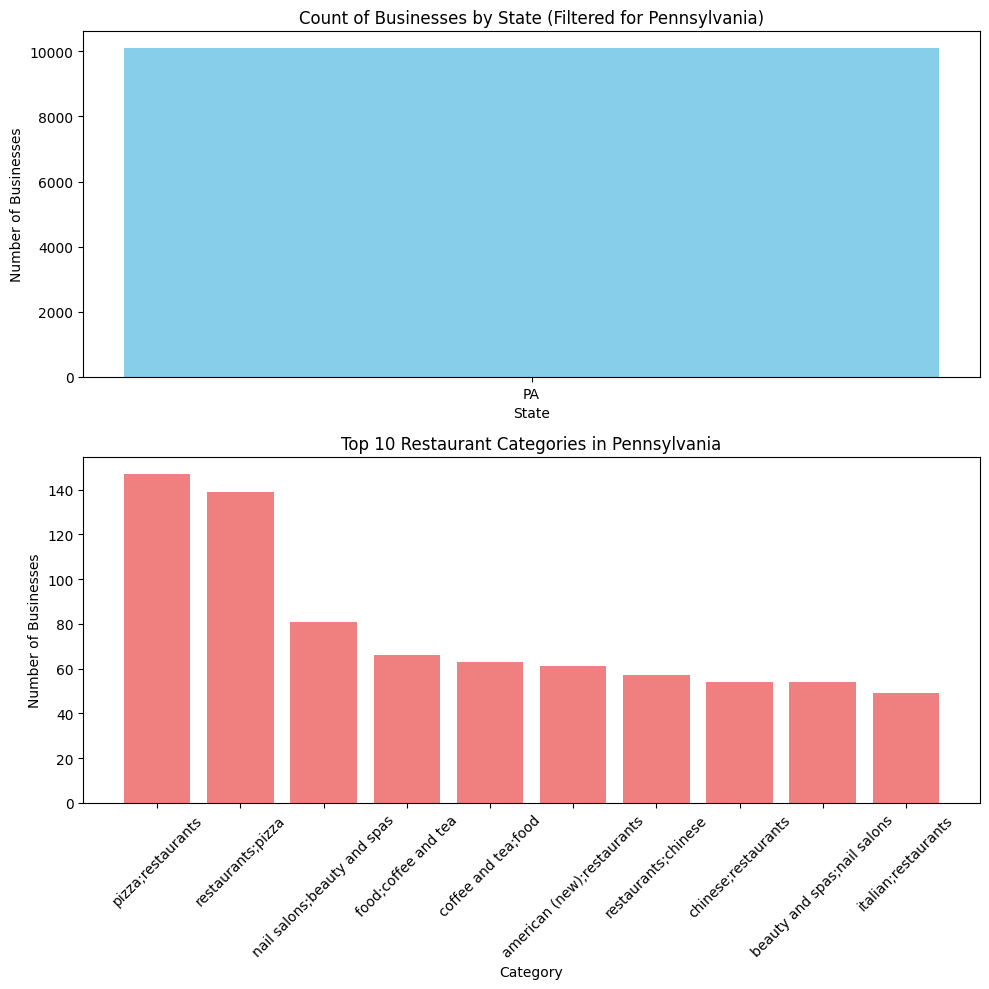

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the filtered Pennsylvania-specific data
pa_business = pd.read_csv('filtered_pa_business.csv')
pa_reviews = pd.read_csv('filtered_pa_reviews.csv')
pa_check_in = pd.read_csv('filtered_pa_checkin.csv')
pa_tip = pd.read_csv('filtered_pa_tip.csv')

# Display the first few rows of each table to understand the structure
print("Pennsylvania Business Data (Head):")
print(pa_business.head())

print("\nPennsylvania Reviews Data (Head):")
print(pa_reviews.head())

print("\nPennsylvania Check-ins Data (Head):")
print(pa_check_in.head())

print("\nPennsylvania Tips Data (Head):")
print(pa_tip.head())

# Summary statistics for Pennsylvania-specific business data
business_counts = pa_business['state'].value_counts()
categories_counts = pa_business['categories_standardized'].value_counts().head(10)  # Top 10 categories

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot 1: Count of businesses in Pennsylvania (should be only 'PA' if filtered correctly)
axs[0].bar(business_counts.index, business_counts.values, color='skyblue')
axs[0].set_title('Count of Businesses by State (Filtered for Pennsylvania)')
axs[0].set_xlabel('State')
axs[0].set_ylabel('Number of Businesses')

# Plot 2: Top 10 Restaurant Categories in Pennsylvania
axs[1].bar(categories_counts.index, categories_counts.values, color='lightcoral')
axs[1].set_title('Top 10 Restaurant Categories in Pennsylvania')
axs[1].set_xlabel('Category')
axs[1].set_ylabel('Number of Businesses')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

# Load the filtered Pennsylvania-specific data from the updated file paths
pa_business = pd.read_csv('/kaggle/working/filtered_pa_business.csv')
pa_reviews = pd.read_csv('/kaggle/working/filtered_pa_reviews.csv')
pa_check_in = pd.read_csv('/kaggle/working/filtered_pa_checkin.csv')
pa_tip = pd.read_csv('/kaggle/working/filtered_pa_tip.csv')

# Display the first few rows of each table
print("Pennsylvania Business Data (Head):")
print(pa_business.head())

print("\nPennsylvania Reviews Data (Head):")
print(pa_reviews.head())

print("\nPennsylvania Check-ins Data (Head):")
print(pa_check_in.head())

print("\nPennsylvania Tips Data (Head):")
print(pa_tip.head())

Pennsylvania Business Data (Head):
              business_id                        name neighborhood  \
0  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
1  EsMcGiZaQuG1OOvL9iUFug          "Any Given Sundae"          NaN   
2  XOSRcvtaKc_Q5H1SAzN20A         "East Coast Coffee"          NaN   
3  NmZtoE3v8RdSJEczYbMT9g      "Complete Dental Care"          NaN   
4  BnuzcebyB1AfxH0kjNWqSg  "Carrabba's Italian Grill"          NaN   

                   address       city state  postal_code   latitude  \
0     "3101 Washington Rd"   McMurray    PA      15317.0  40.291685   
1  "2612 Brandt School Rd"    Wexford    PA      15090.0  40.615102   
2       "737 West Pike St"    Houston    PA      15342.0  40.241548   
3       "107 Whitaker Str"  Homestead    PA      15120.0  40.401488   
4      "245 Lancaster Ave"     Frazer    PA      19355.0  40.041003   

   longitude  stars  review_count  is_open  \
0 -80.104900    3.0            11        1   
1 -80.091349    5.0      

# **Summary Statistics Table:**
Displaying summary statistics such as the number of businesses, average ratings, and average check-ins. This provides a quick overview of the dataset.

In [5]:
# Summary statistics for the business and reviews data
summary = {
    'Total Businesses': [len(pa_business)],
    'Total Reviews': [len(pa_reviews)],
    'Average Rating': [pa_reviews['stars'].mean()],
    'Average Check-ins per Business': [pa_check_in.groupby('business_id').size().mean()],
    'Average Tips per Business': [pa_tip.groupby('business_id').size().mean()]
}

summary_df = pd.DataFrame(summary)
print("Summary Statistics for Pennsylvania-specific Data:")
print(summary_df)


Summary Statistics for Pennsylvania-specific Data:
   Total Businesses  Total Reviews  Average Rating  \
0             10109         229850         3.72878   

   Average Check-ins per Business  Average Tips per Business  
0                       23.771217                   6.102674  


# **Distribution of Ratings**
Plotting a histogram to show the distribution of review ratings in Pennsylvania. This helps to visualize how businesses are rated on average.

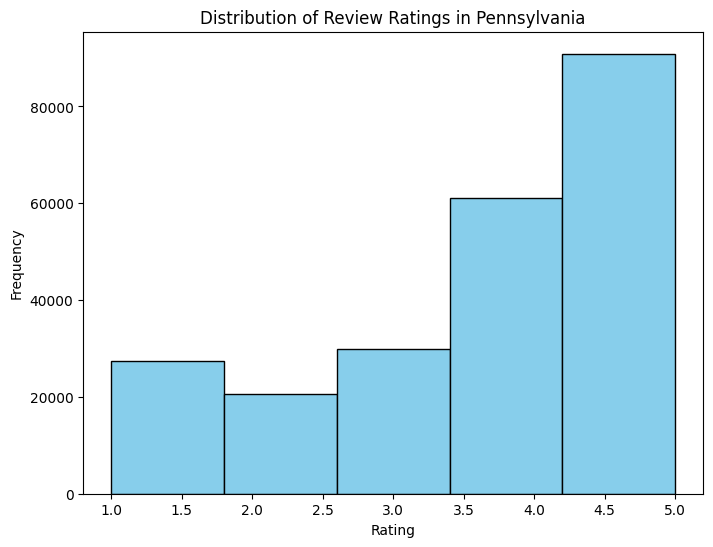

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(pa_reviews['stars'], bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Ratings in Pennsylvania')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# **Top 10 Most Reviewed Businesses**
Display the top 10 businesses with the most reviews in Pennsylvania. This can help identify popular businesses in the area.

In [7]:
top_reviewed = pa_reviews['business_id'].value_counts().head(10)
top_reviewed_businesses = pa_business[pa_business['business_id'].isin(top_reviewed.index)]
print("Top 10 Most Reviewed Businesses in Pennsylvania:")
print(top_reviewed_businesses[['business_id', 'name', 'categories']])

Top 10 Most Reviewed Businesses in Pennsylvania:
                  business_id                         name  \
167    LQFmktF43j2NPncKdNd9mg           "Fat Heads Saloon"   
399    SmkYLXEYhzwUZdS6TAevHg        "Butcher and the Rye"   
852    dLc1d1zwd1Teu2QED5TmlA                 "Noodlehead"   
1553   lKom12WnYEjH5FFemK3M1Q             "Primanti Bros."   
2106   u4sTiCzVeIHZY8OlaL346Q  "Gaucho Parrilla Argentina"   
3028   w_UCGMgok7N9p0XdYBx1VQ              "Primanti Bros"   
4508   sMzNLdhJZGzYirIWt-fMAg             "Sienna Mercato"   
4863   ejaUQ1hYo7Q7xCL1HdPINw          "Church Brew Works"   
7815   JLbgvGM4FXh9zNP4O5ZWjQ            "Meat & Potatoes"   
10100  woXlprCuowrLJswWere3TQ                       "täkō"   

                                              categories  
167    restaurants;bars;nightlife;american (traditional)  
399    nightlife;bars;restaurants;cocktail bars;butch...  
852                             restaurants;noodles;thai  
1553   nightlife;american (new);

# **Pie Chart of Top Categories**
Showing the proportion of each restaurant category in the Pennsylvania dataset to understand the most common types of dining options.

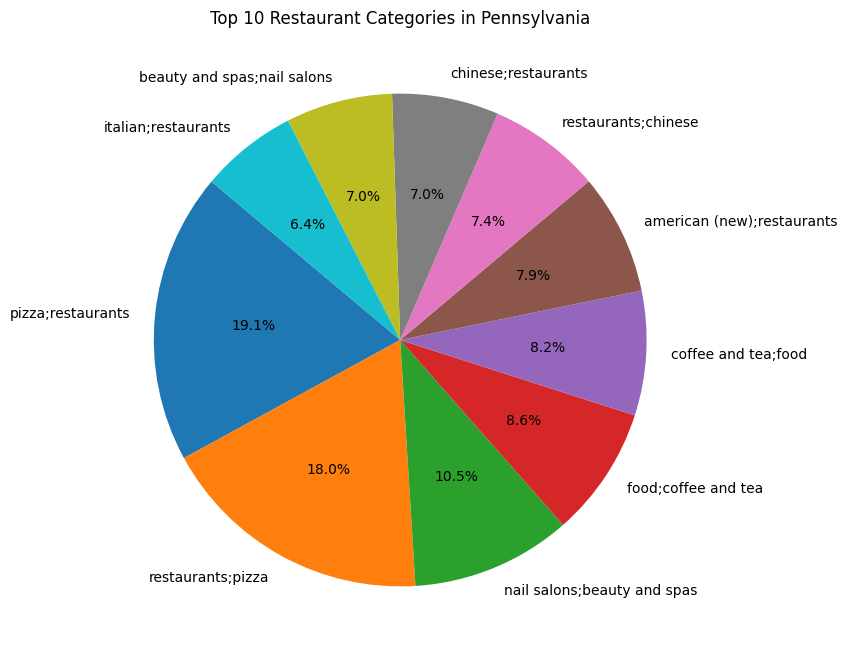

In [11]:
top_categories = pa_business['categories_standardized'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(top_categories, labels=top_categories.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Restaurant Categories in Pennsylvania')
plt.show()